In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

For much of the basis of the code we credit Alexander Van de Kleut, with his demonstration found at https://avandekleut.github.io/vae/ .

In the code above, we import torch, a machine learning library, as well as matplotlib and numpy. We also specify the device, which says whether we want to use a CPU or GPU. In our case we have said that we want to use a GPU if there's one available.

Below, we do some setup: we initialise the number of latent dimensions, the batch size for gradient descent, the number of 'runs' through all the data during training, the step size for gradient descent, import the MNIST dataset into the current directory (this will create a folder called data if one does not exist there already), and convert these images into tensors. 

In [17]:
# Hyperparameters
latent_dims = 2
batch_size = 128
epochs = 10
learning_rate = 1e-3

# DataLoader
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


We now need to create a class defining our model. When we instantiate a class, we typically have an __init___ function which sets up an initial state and attributes, for example, and then below this we can see that the model is built using these objects. The encoder is a two layer feedforward neural network with ReLU activations. The first layer is composed of 512 neurons, which are vectors with 784=28x28 entries, as this is the number of pixels in an MNIST image. The matrix product with a given vector is computed and then the function $\max \{ 0, x\}$ is applied entry-wise. Finally, another linear layer with number of neurons equal to the number of latent dimensions (with now each neuron having 512 entries) is applied to give our embedding. This could be interpreted as our $f$ in our goal to approximately solve $g(f(x)) = \mathrm{\textbf{I}}$. 

The decoder is basically the exact reverse, apart from that we apply a sigmoid activation at the end. The reason for this is that the pixel intensity of a grey scale image ranges from 0 to 1, and without this restriction this would be another thing the model would have to learn. The autoencoder is the composition of these two functions.

In [18]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z=torch.sigmoid(self.linear2(z))
        return z.reshape(-1, 1, 28, 28)
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    

In the cell below, we define our loss function. We use the binary cross entropy loss, instantiate our model, and then specify the optimiser we want to use (Adam is a standard first port of call).

In [19]:
def loss_function_ae(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return recon_loss

AE = Autoencoder(latent_dims).to(device)
optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate)


We now need to train our model. The below is a fairly standard training loop, in which we iterate over the batches in the training data and use the backpropagation algorithm (really just the chain rule) to evaluate the gradient.

In [20]:
for epoch in range(1, epochs + 1):
    AE.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = AE(data)
        loss = loss_function_ae(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1, Loss: 178.7890
Epoch 2, Loss: 159.4150
Epoch 3, Loss: 154.9809
Epoch 4, Loss: 152.4829
Epoch 5, Loss: 150.7275
Epoch 6, Loss: 149.4308
Epoch 7, Loss: 148.3675
Epoch 8, Loss: 147.5254
Epoch 9, Loss: 146.7159
Epoch 10, Loss: 146.0224


In Pytorch, models behave differently when when we're training them vs. running them, so we need to convert to model.eval() to see how well the training has gone. Under the hood, this makes sure we're not computing any gradients as we don't need them any more, and also gets rid of any layers/functionalities which help training. These might include max pooling and dropout. 

In [21]:
AE.eval()

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

Now, we can plot our embeddings! In the below, we take all of our data and apply the encoder and plot their positions in the latent space (which here we have specified to be two dimensional for visualisation).

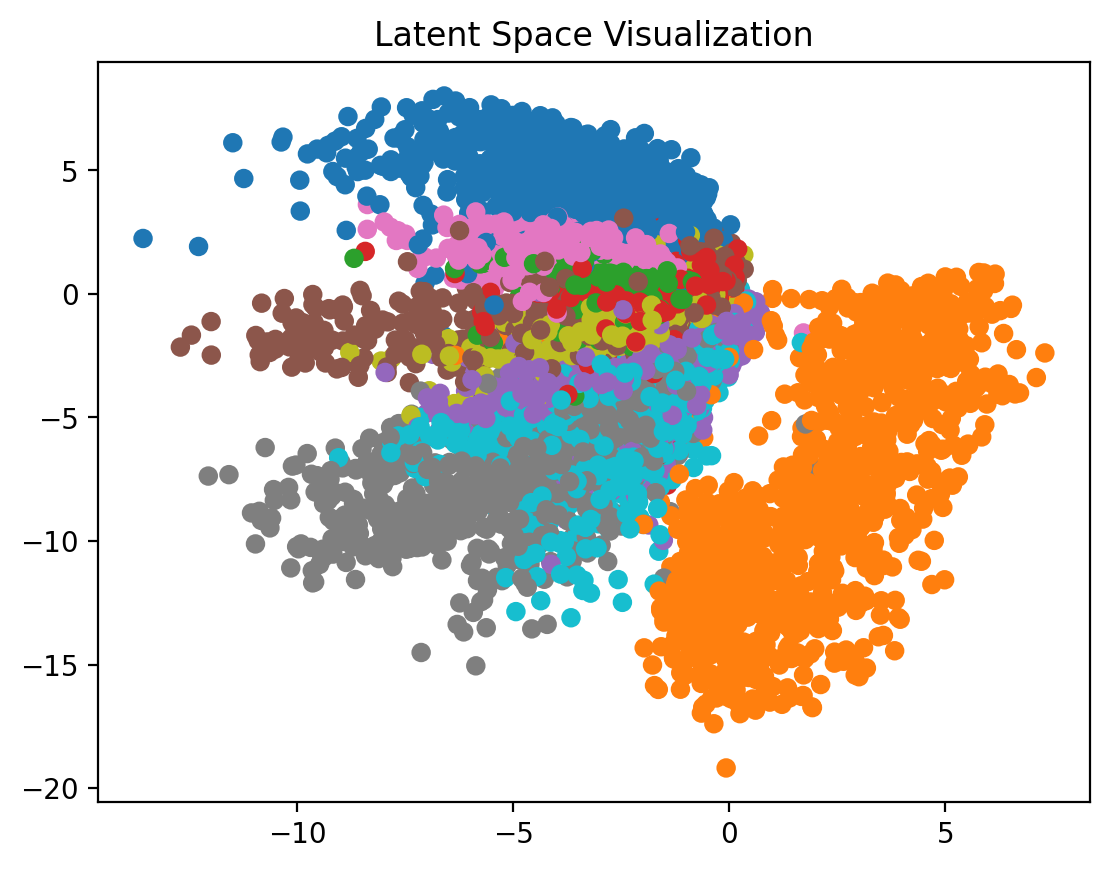

In [33]:
def plot_latent(model, data_loader, num_batches=100):
    model.eval()
    all_z = []
    all_labels = []

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)

            # Handle both AE and VAE
            encoder_output = model.encoder(x)
            if isinstance(encoder_output, tuple):  # VAE: returns (mu, logvar)
                mu, logvar = encoder_output
                z = model.reparameterize(mu, logvar)
            else:  # AE: returns latent vector directly
                z = encoder_output

            all_z.append(z.cpu())
            all_labels.append(y)

            if i >= num_batches:
                break

    z = torch.cat(all_z).numpy()
    labels = torch.cat(all_labels).numpy()

    plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
    #plt.colorbar()
    plt.title("Latent Space Visualization")
    plt.show()
    

plot_latent(AE, data, num_batches=100)

In the cell below, we can do a neat visualisation of what the decoder is doing by reconstructing a grid of samples in the latent space. Note that in the top and bottom left, our reconstructions don't seem to be particularly meaningful. If you look at the scatter plot above, it becomes clear that this is because the encoder has not mapped any of the data to these regions. This means nothing can be learnt about how these points are reconstructed. 

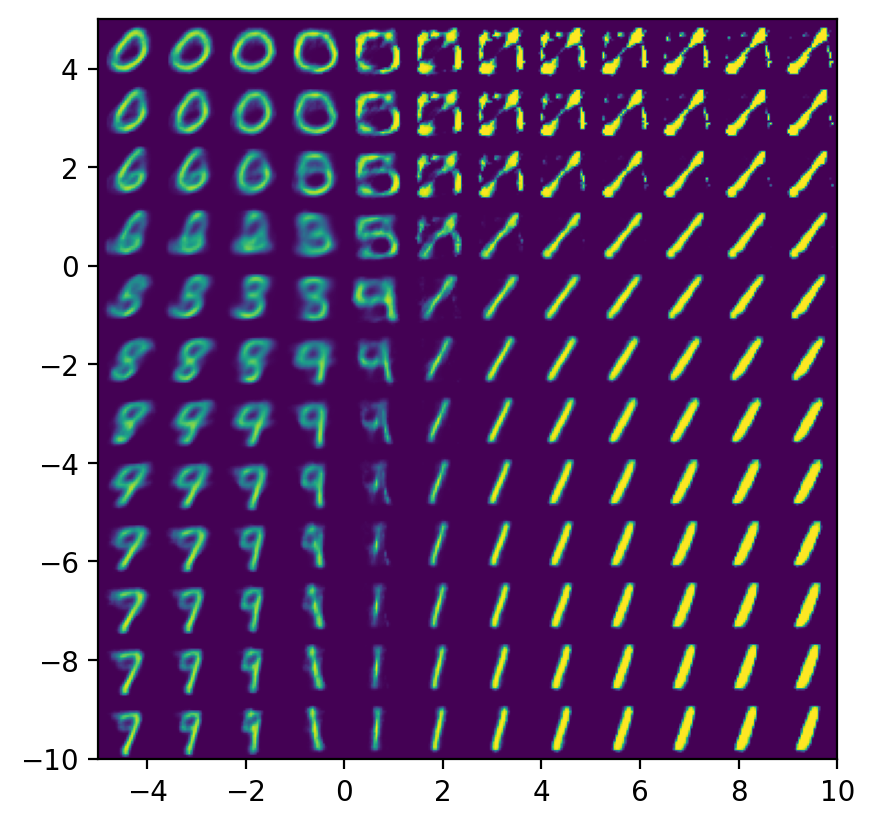

In [27]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

plot_reconstructed(AE, r0=(-5, 10), r1=(-10, 5), n=12)

In the image below, we embed an image in the latent space and then decode them. We can compare them side by side to see how well our model has learnt a representation of the images. These are not dreadful, but if one increased the number of latent dimensions the reconstruction would improve markedly. 

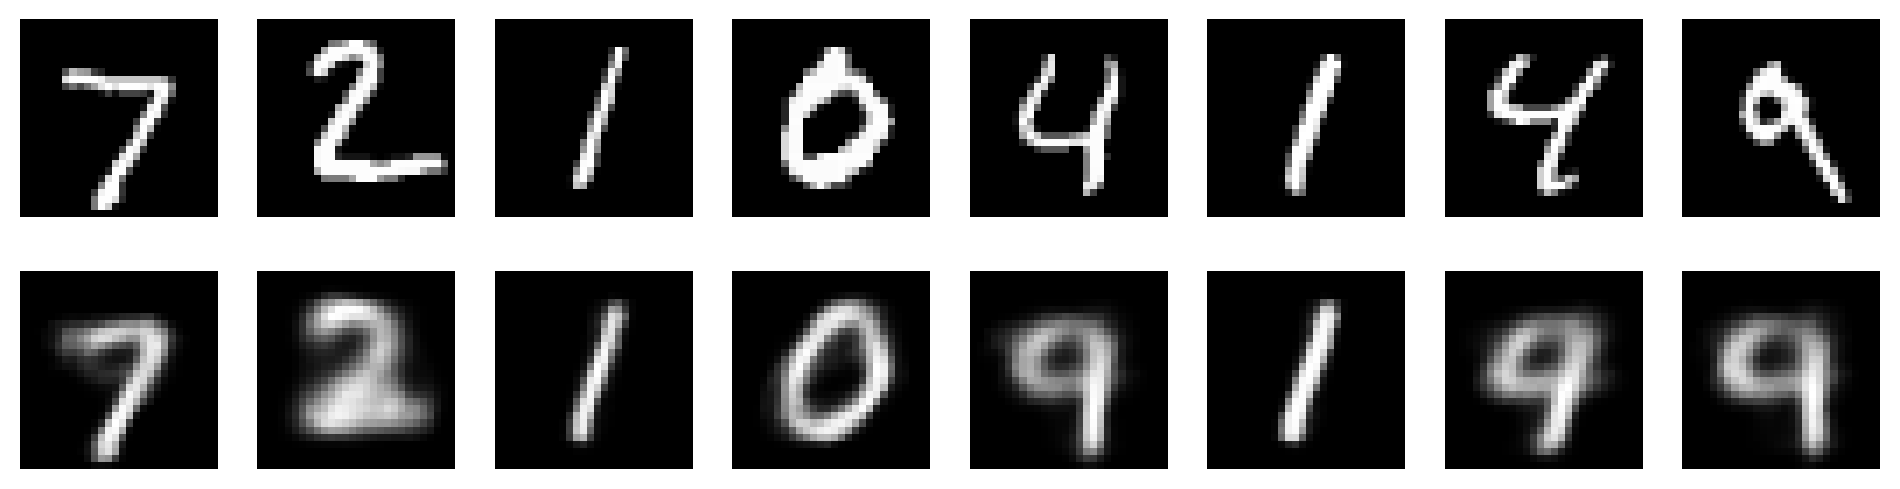

In [28]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:8].to(device)
    recon= AE(data)

    data = data.cpu()
    recon = recon.cpu()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(data[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()

We now similarly set up a variational autoencoder, in which we have our variational encoder. Note that we still use the Decoder class above as before, meaning it's only our encoder which has changed. Our encoder returns now a mean function and a log-variance function at each point in the latent space. Our reparametrisation function in the class VariationalAutoencoder is used to allow our optimisation via backpropagation to work.

In [29]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.fc_mean = nn.Linear(512, latent_dims)      # Mean head
        self.fc_logvar = nn.Linear(512, latent_dims)    # Log-variance head

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h = F.relu(self.linear1(x))
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        return z_mean, z_logvar
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

Our loss function is still the binary cross entropy loss, except that we now have a KL divergence term. This measures the difference between the learned distribution in the latent space and a prior which we put on the data (normally that it follows a standard normal distribution). This term avoids memorisation of training data. One could imagine that without this, the model might learn an unstructured latent space in which every training example is mapped to a distinct areas of the latent space. The idea is that instead of this, we have a structured latent space in which meaningful groupings are learnt.

In [30]:
def loss_function(recon_x, x, mu, logvar):
    recon_x = recon_x.view(x.size(0), -1)
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + 0.05 * KLD

For the VAE experiments, we will increase the dimensionality of the latent space. This is partly to illustrate that greater accuracy is obtained this way but also to show some nice dimensionality reduction visualisations.

In [31]:
latent_dims=10
VAE = VariationalAutoencoder(latent_dims).to(device)
optimizer=torch.optim.Adam(VAE.parameters(), lr=1e-3)

In [32]:
for epoch in range(1, epochs + 1):
    VAE.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = VAE(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1, Average loss: 137.3724
Epoch 2, Average loss: 100.4184
Epoch 3, Average loss: 95.3439
Epoch 4, Average loss: 92.6104
Epoch 5, Average loss: 90.7904
Epoch 6, Average loss: 89.4580
Epoch 7, Average loss: 88.4365
Epoch 8, Average loss: 87.5507
Epoch 9, Average loss: 86.8554
Epoch 10, Average loss: 86.2324


In [8]:
VAE.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (fc_mean): Linear(in_features=512, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

Remember that this function won't work unless we have the a latent space with two dimensions. 

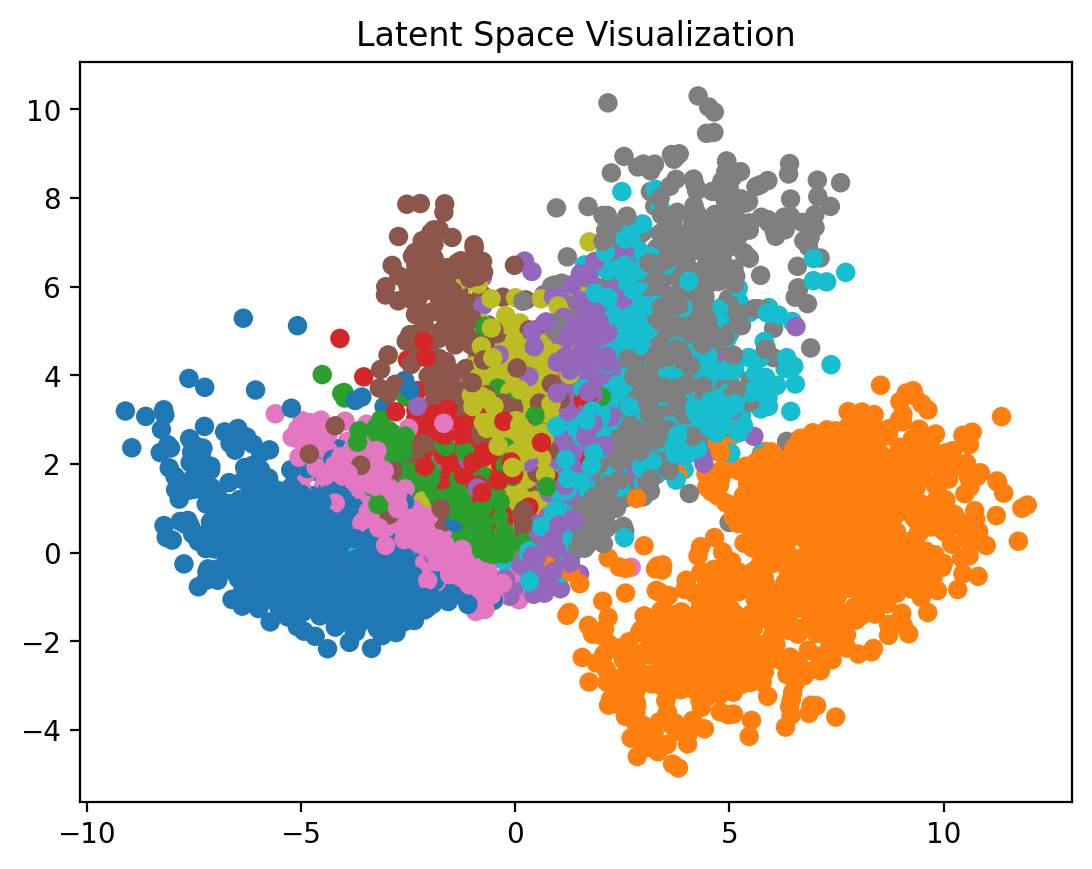

In [9]:
plot_latent(VAE, test_loader, num_batches=100)

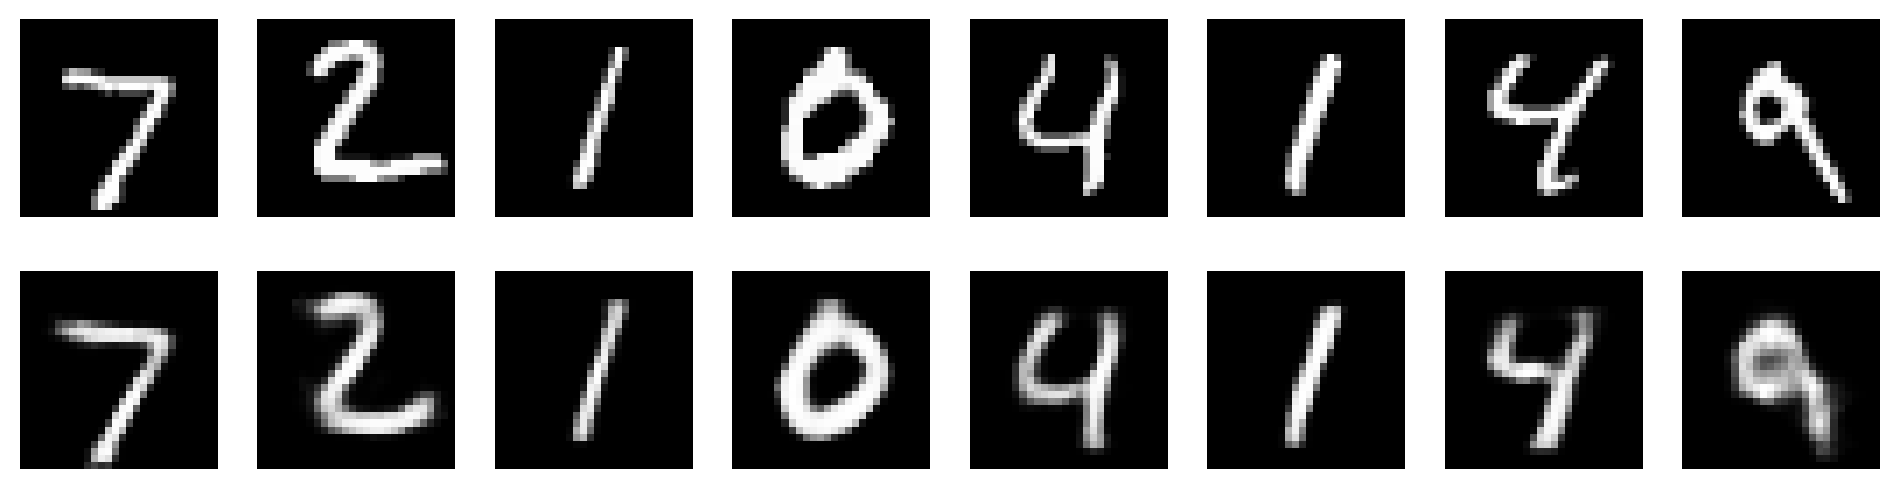

In [34]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:8].to(device)
    recon, _, _ = VAE(data)

    data = data.cpu()
    recon = recon.cpu()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(data[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()

The same point on this needing dimension 2 applies. 

In [35]:

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

plot_reconstructed(VAE, r0=(-5, 10), r1=(-10, 5), n=12)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 10x512)

Below, we have code which does PCA for the latent embeddings, which is the same idea as the two dimensional scatter plot.

In [38]:
latents = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar = VAE.encoder(x)
        z = VAE.reparameterize(mu, logvar)
        latents.append(z.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
z_pca = pca.fit_transform(latents)

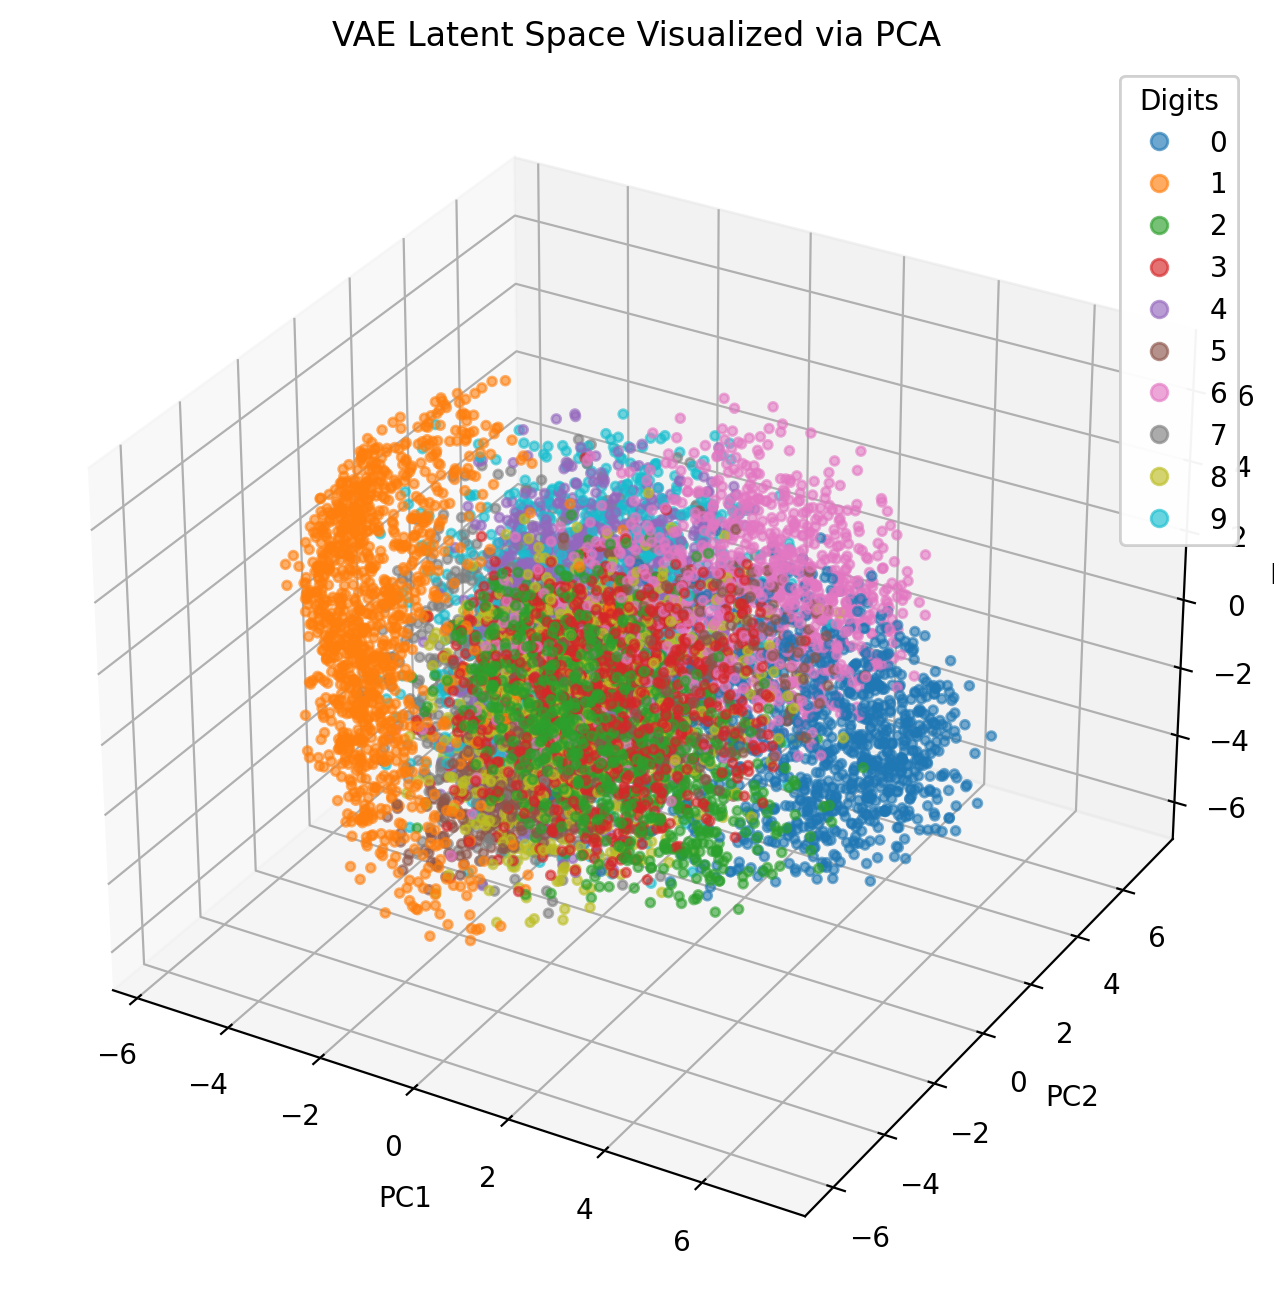

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=labels, cmap='tab10', alpha=0.6, s=10)
legend = ax.legend(*scatter.legend_elements(), title="Digits")
ax.add_artist(legend)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('VAE Latent Space Visualized via PCA')

plt.show()

There is even a library with interactive visualisation!

In [41]:
import plotly.express as px
import pandas as pd

# Convert data to DataFrame
df = pd.DataFrame(z_pca, columns=['PC1', 'PC2', 'PC3'])
df['label'] = labels

fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color=df['label'].astype(str),
                    title="Interactive 3D PCA of VAE Latents", opacity=0.7)
fig.show()